In [1]:
!pip install --upgrade tensorflow --user
!pip install tf-quant-finance
!pip install QuantLib-Python

In [2]:
import os
# reduce number of threads
os.environ['TF_NUM_INTEROP_THREADS'] = '1'
os.environ['TF_NUM_INTRAOP_THREADS'] = '1'

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tf_quant_finance as tff 
import tensorflow as tf
import functools
import pandas as pd
import time
import QuantLib as ql

In [3]:
!nvidia-smi

Thu Apr 28 13:51:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#@title Set up parameters

dtype = tf.float64 #@param
num_samples = 200000 #@param
num_timesteps = 100 #@param
nb_options = 20

# expiries =tf.constant( [0.0, 0.5, 1.0], dtype=dtype) # This can be a rank 1 Tensor
dt = 1. / num_timesteps
# times = [1.0]
times = tf.linspace(tf.constant(0.0, dtype=dtype), tf.constant(1.0, dtype=dtype), num_timesteps)
rate = tf.constant(0.03, dtype=dtype)
sigma = tf.constant(0.1, dtype=dtype)
spot = tf.constant(700, dtype=dtype)
strikes = tf.linspace(0.5*spot, 1.5*spot, nb_options)

def set_up_pricer(times, watch_params=False):
    """Set up European option pricing function under Black-Scholes model.
    
    Args:
        expiries: List of expiries at which to to sample the trajectories.
        watch_params: A Python bool. When `True`, gradients of the price function wrt the inputs
          are computed more efficiently. 
    Returns:
     A callable that accepts a rank 1 tensor of strikes, and scalar values for 
     the spots and  volatility values. The callable outputs prices of
     the European call options on the grid `expiries x strikes`.
    """
    def price_eu_options(strikes, spot, sigma):
        # Define drift and volatility functions. 
        def drift_fn(t, x):
          del t, x
          return rate - 0.5 * sigma**2
        def vol_fn(t, x):
          del t, x
          return tf.reshape(sigma, [1, 1])
        # Use GenericItoProcess class to set up the Ito process
        process = tff.models.GenericItoProcess(
            dim=1,
            drift_fn=drift_fn,
            volatility_fn=vol_fn,
            dtype=dtype)
        log_spot = tf.math.log(tf.reduce_mean(spot))
        if watch_params:
            watch_params_list = [sigma]
        else:
            watch_params_list = None
        paths = process.sample_paths(
            times=times, num_samples=num_samples,
            initial_state=log_spot, 
            watch_params=watch_params_list,
            # Select a random number generator
            random_type=tff.math.random.RandomType.PSEUDO_ANTITHETIC,
            time_step=dt)
        
        # tf.print('paths', paths.shape, paths)
        # paths_reduced = tf.gather_nd(paths, [[:, 0]])
        paths_reduced = tf.expand_dims(paths[:, -1, :], axis=-1)
        # tf.print('paths_reduced', paths_reduced.shape, paths_reduced)
        # tf.print('strikes', strikes.shape, strikes)
        # tf.print('tf.math.exp(paths) - strikes', (tf.math.exp(paths) - strikes).shape, tf.math.exp(paths) - strikes)


        prices = (tf.exp(-tf.expand_dims(rate * times[-1], axis=-1))
                  * tf.reduce_mean(tf.nn.relu(tf.math.exp(paths_reduced) - strikes), 0))
        # tf.print(prices.shape, prices)
        return prices
    return price_eu_options

price_eu_options = tf.function(set_up_pricer(times, watch_params=True),
                               input_signature=[
                                                tf.TensorSpec([None], dtype=tf.float64),
                                                tf.TensorSpec([], dtype=tf.float64),
                                                tf.TensorSpec([], dtype=tf.float64)
                               ])
price_eu_options_xla = tf.function(set_up_pricer(times, watch_params=True),
                               input_signature=[
                                                tf.TensorSpec([None], dtype=tf.float64),
                                                tf.TensorSpec([], dtype=tf.float64),
                                                tf.TensorSpec([], dtype=tf.float64)
                               ], jit_compile=True)
# price_eu_options_xla = tf.function(set_up_pricer(times), jit_compile=True)
print(set_up_pricer(times)(strikes, spot, sigma))

# price_eu_options_xla = set_up_pricer(times)

tf.Tensor(
[[3.60338747e+02 3.24585491e+02 2.88832234e+02 2.53079056e+02
  2.17327614e+02 1.81598588e+02 1.46033947e+02 1.11217338e+02
  7.86452551e+01 5.06197019e+01 2.92101161e+01 1.50187560e+01
  6.87783589e+00 2.81129854e+00 1.04804916e+00 3.56017581e-01
  1.12100116e-01 3.41514665e-02 9.54552710e-03 2.58798816e-03]], shape=(1, 20), dtype=float64)


In [5]:
#@title Pricing times on CPU and GPU platforms

time_start = time.time()
with tf.device("/cpu:0"):
    price_cpu_nograph = set_up_pricer(times)(strikes, spot, sigma)
time_end = time.time()
time_price_cpu_nograph = time_end - time_start
print(price_cpu_nograph[:10].numpy())

time_start = time.time()
with tf.device("/gpu:0"):
    set_up_pricer(times)(strikes, spot, sigma)
time_end = time.time()
time_price_gpu_nograph = time_end - time_start

# GPU without XLA
time_start = time.time()
with tf.device("/gpu:0"):
    price_eu_options(strikes, spot, sigma)
time_end = time.time()
time_price_gpu0 = time_end - time_start
# Second run (excludes graph optimization time)
time_start = time.time()
with tf.device("/gpu:0"):
    prices = price_eu_options(strikes, spot, sigma)
time_end = time.time()
time_price_gpu = time_end - time_start

# CPU without XLA
time_start = time.time()
with tf.device("/cpu:0"):
    price_eu_options(strikes, spot, sigma)
time_end = time.time()
time_price_cpu0 = time_end - time_start    
time_start = time.time()
with tf.device("/cpu:0"):
    prices = price_eu_options(strikes, spot, sigma)
time_end = time.time()
time_price_cpu = time_end - time_start

print('time_price_cpu_nograph', time_price_cpu_nograph, nb_options/time_price_cpu_nograph)
print('time_price_gpu_nograph', time_price_gpu_nograph, nb_options/time_price_gpu_nograph)

print('time_price_gpu0', time_price_gpu0, nb_options/time_price_gpu0)
print('time_price_gpu', time_price_gpu, nb_options/time_price_gpu)

print('time_price_cpu0', time_price_cpu0, nb_options/time_price_cpu0)
print('time_price_cpu', time_price_cpu, nb_options/time_price_cpu)


[[3.60368036e+02 3.24614780e+02 2.88861523e+02 2.53108267e+02
  2.17356321e+02 1.81625773e+02 1.46062575e+02 1.11261359e+02
  7.87268620e+01 5.07537097e+01 2.93926805e+01 1.51503944e+01
  6.95512920e+00 2.85264195e+00 1.05496295e+00 3.53807525e-01
  1.06035658e-01 3.06347016e-02 7.91393784e-03 1.19349436e-03]]
time_price_cpu_nograph 13.00383734703064 1.5380075485615712
time_price_gpu_nograph 3.2956666946411133 6.068574844816925
time_price_gpu0 14.956080913543701 1.3372487161318245
time_price_gpu 3.252159595489502 6.1497596943700055
time_price_cpu0 21.29390835762024 0.9392357506245582
time_price_cpu 20.91956114768982 0.9560430000802685


In [6]:
#@title Pricing times on CPU and GPU platforms

time_start = time.time()
with tf.device("/cpu:0"):
    price_cpu_nograph = set_up_pricer(times)(strikes, spot, sigma)
time_end = time.time()
time_price_cpu_nograph = time_end - time_start
print(price_cpu_nograph[:10].numpy())

time_start = time.time()
with tf.device("/gpu:0"):
    set_up_pricer(times)(strikes, spot, sigma)
time_end = time.time()
time_price_gpu_nograph = time_end - time_start

# GPU without XLA
time_start = time.time()
with tf.device("/gpu:0"):
    price_eu_options_xla(strikes, spot, sigma)
time_end = time.time()
time_price_gpu0 = time_end - time_start
# Second run (excludes graph optimization time)
time_start = time.time()
with tf.device("/gpu:0"):
    prices = price_eu_options_xla(strikes, spot, sigma)
time_end = time.time()
time_price_gpu = time_end - time_start

# CPU without XLA
time_start = time.time()
with tf.device("/cpu:0"):
    price_eu_options_xla(strikes, spot, sigma)
time_end = time.time()
time_price_cpu0 = time_end - time_start    
time_start = time.time()
with tf.device("/cpu:0"):
    prices = price_eu_options_xla(strikes, spot, sigma)
time_end = time.time()
time_price_cpu = time_end - time_start

print('time_price_cpu_nograph', time_price_cpu_nograph, nb_options/time_price_cpu_nograph)
print('time_price_gpu_nograph', time_price_gpu_nograph, nb_options/time_price_gpu_nograph)

print('time_price_gpu0 XLA', time_price_gpu0, nb_options/time_price_gpu0)
print('time_price_gpu XLA', time_price_gpu, nb_options/time_price_gpu)

print('time_price_cpu0 XLA', time_price_cpu0, nb_options/time_price_cpu0)
print('time_price_cpu XLA', time_price_cpu, nb_options/time_price_cpu)


[[3.60334530e+02 3.24581274e+02 2.88828017e+02 2.53074805e+02
  2.17322922e+02 1.81587786e+02 1.46011200e+02 1.11194145e+02
  7.86251466e+01 5.06480304e+01 2.92709551e+01 1.50452754e+01
  6.84930597e+00 2.78225796e+00 1.00601796e+00 3.23456154e-01
  9.27701608e-02 2.42283369e-02 6.52094647e-03 1.98332650e-03]]
time_price_cpu_nograph 6.266579866409302 3.191533567968365
time_price_gpu_nograph 3.5035316944122314 5.708525494973521
time_price_gpu0 XLA 6.348849534988403 3.1501770344029003
time_price_gpu XLA 3.952253580093384 5.060404044096645
time_price_cpu0 XLA 38.28629755973816 0.5223801013611717
time_price_cpu XLA 37.12159037590027 0.5387700202894382


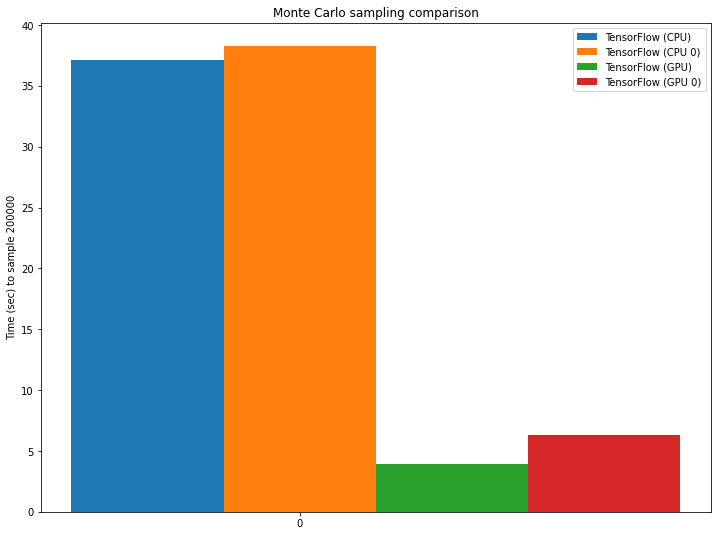

In [7]:
#@title Plot the results

ind = np.arange(1)  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

fig.set_figheight(9)
fig.set_figwidth(12)

ax.bar(ind - width/8, [time_price_cpu], width / 8,
       label='TensorFlow (CPU)')
ax.bar(ind, [time_price_cpu0], width / 8,
       label='TensorFlow (CPU 0)')
ax.bar(ind + width/8, [time_price_gpu], width / 8,
       label='TensorFlow (GPU)')
ax.bar(ind + width/4, [time_price_gpu0], width / 8,
       label='TensorFlow (GPU 0)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (sec) to sample {}'.format(num_samples))
ax.set_title('Monte Carlo sampling comparison')
ax.set_xticks(ind)
ax.legend()


plt.show()

In [8]:
# Delta
@tf.function
def delta_fn(spot):
    fn = lambda spot: price_eu_options(strikes, spot, sigma)
    return tff.math.fwd_gradient(fn, spot,
                                 use_gradient_tape=True)
# Theta # not tested in https://colab.research.google.com/github/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Monte_Carlo_Euler_Scheme.ipynb
# Rho # not tested in https://colab.research.google.com/github/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Monte_Carlo_Euler_Scheme.ipynb
# Vega
@tf.function
def vega_fn(sigma):
    fn = lambda sigma: price_eu_options(strikes, spot, sigma)
    return tff.math.fwd_gradient(fn, sigma,
                                 use_gradient_tape=True)



# Delta
@tf.function(jit_compile=True)
def delta_fn_xla(spot):
    fn = lambda spot: price_eu_options(strikes, spot, sigma)
    return tff.math.fwd_gradient(fn, spot,
                                 use_gradient_tape=True)
# Theta # not tested in https://colab.research.google.com/github/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Monte_Carlo_Euler_Scheme.ipynb
# Rho # not tested in https://colab.research.google.com/github/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Monte_Carlo_Euler_Scheme.ipynb
# Vega
@tf.function(jit_compile=True)
def vega_fn_xla(sigma):
    fn = lambda sigma: price_eu_options(strikes, spot, sigma)
    return tff.math.fwd_gradient(fn, sigma,
                                 use_gradient_tape=True)

In [9]:
# Delta CPU
## warmup
with tf.device("/cpu:0"):
    delta_fn(spot)
## measure time
time_start = time.time()
with tf.device("/cpu:0"):
    deltas_cpu = delta_fn(spot)
time_end = time.time()
time_delta_cpu = time_end - time_start


# Vega CPU
## warmup
with tf.device("/cpu:0"):
    vega_fn(sigma)
## measure time
time_start = time.time()
with tf.device("/cpu:0"):
    vegas_cpu = vega_fn(sigma)
time_end = time.time()
time_vega_cpu = time_end - time_start


# Delta GPU
## warmup
with tf.device("/gpu:0"):
    delta_fn(spot)
## measure time
time_start = time.time()
with tf.device("/gpu:0"):
    deltas_gpu = delta_fn(spot)
time_end = time.time()
time_delta_gpu = time_end - time_start

# Vega GPU
## warmup
with tf.device("/gpu:0"):
    vega_fn(sigma)
## measure time
time_start = time.time()
with tf.device("/gpu:0"):
    vegas_gpu = vega_fn(sigma)
time_end = time.time()
time_vega_gpu = time_end - time_start



print('time_delta_cpu', time_delta_cpu, nb_options/time_delta_cpu)
print('time_vega_cpu', time_vega_cpu, nb_options/time_vega_cpu)
print('time_delta_gpu', time_delta_gpu, nb_options/time_delta_gpu)
print('time_vega_gpu', time_vega_gpu, nb_options/time_vega_gpu)

print(deltas_cpu)
print(vegas_cpu)
print(deltas_gpu)
print(vegas_gpu)

time_delta_cpu 65.83118057250977 0.30380740290645397
time_vega_cpu 66.24241948127747 0.30192133917531094
time_delta_gpu 4.984381675720215 4.012533810848286
time_vega_gpu 5.385260343551636 3.71384087752567
tf.Tensor(
[[9.99987073e-01 9.99987073e-01 9.99987073e-01 9.99987073e-01
  9.99919376e-01 9.99017922e-01 9.91549965e-01 9.60804668e-01
  8.79587007e-01 7.31685760e-01 5.35583730e-01 3.40307344e-01
  1.87398542e-01 9.02132330e-02 3.77527623e-02 1.39803045e-02
  4.46934731e-03 1.17002895e-03 3.44872967e-04 7.41591771e-05]], shape=(1, 20), dtype=float64)
tf.Tensor(
[[5.75396060e-02 5.75396060e-02 5.75396060e-02 5.75396060e-02
  2.55685342e-01 2.76588894e+00 1.61726850e+01 5.95510683e+01
  1.40535874e+02 2.30738531e+02 2.78168719e+02 2.56676781e+02
  1.88521199e+02 1.13899476e+02 5.80498211e+01 2.52155052e+01
  9.78809958e+00 3.51009919e+00 1.04919010e+00 2.82652961e-01]], shape=(1, 20), dtype=float64)
tf.Tensor(
[[1.00001639e+00 1.00001639e+00 1.00001639e+00 1.00001013e+00
  9.99915597e-

In [10]:
# GPU without XLA
time_start = time.time()
with tf.device("/gpu:0"):
    price_eu_options(strikes, spot, sigma)
    delta_fn(spot)
    vega_fn(sigma)
time_end = time.time()
time_pricegreek_gpu0 = time_end - time_start
# Second run (excludes graph optimization time)
time_start = time.time()
with tf.device("/gpu:0"):
    price_eu_options(strikes, spot, sigma)
    delta_fn(spot)
    vega_fn(sigma)
time_end = time.time()
time_pricegreek_gpu = time_end - time_start

# CPU without XLA
time_start = time.time()
with tf.device("/cpu:0"):
    prices = price_eu_options(strikes, spot, sigma)
    deltas = delta_fn(spot)
    vegas = vega_fn(sigma)
time_end = time.time()
time_pricegreek_cpu0 = time_end - time_start    
time_start = time.time()
with tf.device("/cpu:0"):
    price_eu_options(strikes, spot, sigma)
    delta_fn(spot)
    vega_fn(sigma)
time_end = time.time()
time_pricegreek_cpu = time_end - time_start

print('time_pricegreek_gpu0', time_pricegreek_gpu0, nb_options/time_pricegreek_gpu0)
print('time_pricegreek_cpu0', time_pricegreek_cpu0, nb_options/time_pricegreek_cpu0)
print('time_pricegreek_gpu', time_pricegreek_gpu, nb_options/time_pricegreek_gpu)
print('time_pricegreek_cpu', time_pricegreek_cpu, nb_options/time_pricegreek_cpu)

print('prices', prices)
print('deltas', deltas)
print('vegas', vegas)

time_pricegreek_gpu0 11.703298807144165 1.7089198805888126
time_pricegreek_cpu0 147.8590567111969 0.13526394963458105
time_pricegreek_gpu 12.059552431106567 1.6584363403414324
time_pricegreek_cpu 149.23513221740723 0.13401670037631488
prices tf.Tensor(
[[3.60343058e+02 3.24589801e+02 2.88836545e+02 2.53083426e+02
  2.17331720e+02 1.81602061e+02 1.46028233e+02 1.11215826e+02
  7.86575538e+01 5.06534922e+01 2.92792915e+01 1.50505555e+01
  6.88465601e+00 2.81085101e+00 1.02319477e+00 3.39394862e-01
  1.07623393e-01 3.23460608e-02 8.79331739e-03 2.34462456e-03]], shape=(1, 20), dtype=float64)
deltas tf.Tensor(
[[1.00002181e+00 1.00002181e+00 1.00002181e+00 1.00001870e+00
  9.99957801e-01 9.98907799e-01 9.91246678e-01 9.60434020e-01
  8.79177410e-01 7.30893325e-01 5.35732936e-01 3.41357469e-01
  1.87987983e-01 9.04616553e-02 3.82541978e-02 1.46188214e-02
  4.99491596e-03 1.34273555e-03 3.94950778e-04 7.46086211e-05]], shape=(1, 20), dtype=float64)
vegas tf.Tensor(
[[2.30391126e-02 2.3039112

In [11]:
# GPU with XLA
time_start = time.time()
with tf.device("/gpu:0"):
    price_eu_options_xla(strikes, spot, sigma)
    delta_fn_xla(spot)
    vega_fn_xla(sigma)
time_end = time.time()
time_pricegreek_gpu0 = time_end - time_start
# Second run (excludes graph optimization time)
time_start = time.time()
with tf.device("/gpu:0"):
    price_eu_options_xla(strikes, spot, sigma)
    delta_fn_xla(spot)
    vega_fn_xla(sigma)
time_end = time.time()
time_pricegreek_gpu = time_end - time_start

# CPU without XLA
time_start = time.time()
with tf.device("/cpu:0"):
    prices = price_eu_options_xla(strikes, spot, sigma)
    deltas = delta_fn_xla(spot)
    vegas = vega_fn_xla(sigma)
time_end = time.time()
time_pricegreek_cpu0 = time_end - time_start    
time_start = time.time()
with tf.device("/cpu:0"):
    price_eu_options_xla(strikes, spot, sigma)
    delta_fn_xla(spot)
    vega_fn_xla(sigma)
time_end = time.time()
time_pricegreek_cpu = time_end - time_start

print('time_pricegreek_gpu0 XLA', time_pricegreek_gpu0, nb_options/time_pricegreek_gpu0)
print('time_pricegreek_cpu0 XLA', time_pricegreek_cpu0, nb_options/time_pricegreek_cpu0)
print('time_pricegreek_gpu XLA', time_pricegreek_gpu, nb_options/time_pricegreek_gpu)
print('time_pricegreek_cpu XLA', time_pricegreek_cpu, nb_options/time_pricegreek_cpu)

print('prices', prices)
print('deltas', deltas)
print('vegas', vegas)

time_pricegreek_gpu0 XLA 17.39311981201172 1.1498799649610856
time_pricegreek_cpu0 XLA 115.45632004737854 0.17322568389320583
time_pricegreek_gpu XLA 11.979508399963379 1.6695175905599882
time_pricegreek_cpu XLA 111.89814448356628 0.17873397358199503
prices tf.Tensor(
[[3.60360091e+02 3.24606835e+02 2.88853578e+02 2.53100322e+02
  2.17348449e+02 1.81618020e+02 1.46051150e+02 1.11254545e+02
  7.87040755e+01 5.07192337e+01 2.93406301e+01 1.51167680e+01
  6.92974043e+00 2.84749246e+00 1.05378646e+00 3.48313210e-01
  1.06765943e-01 2.98215760e-02 7.53132330e-03 1.64342184e-03]], shape=(1, 20), dtype=float64)
deltas tf.Tensor(
[[1.00000250e+00 1.00000250e+00 1.00000250e+00 9.99999336e-01
  9.99938619e-01 9.98960755e-01 9.91413558e-01 9.60751256e-01
  8.79207782e-01 7.31195243e-01 5.36110927e-01 3.41102417e-01
  1.88519500e-01 9.01250824e-02 3.80758105e-02 1.43295855e-02
  4.59440808e-03 1.27971618e-03 3.45386244e-04 9.66195062e-05]], shape=(1, 20), dtype=float64)
vegas tf.Tensor(
[[-4.23438

In [12]:
# @title Monte Carlo sampling in QuantLib

def ql_price(strike):
    num_samples = 200000 #@param
    num_timesteps = 100#100 #@param
    expiry = 1.0

    calculation_date = ql.Date(1, 1, 2010)
    maturity_date = ql.Date(1, 1, 2011)
    day_count = ql.Thirty360()
    calendar = ql.NullCalendar()

    ql_strike_price = strike
    sigma_ql = 0.1
    ql_volatility = ql.SimpleQuote(sigma_ql)
    ql_risk_free_rate = 0.03
    option_type = ql.Option.Call

    ql.Settings.instance().evaluationDate = calculation_date
    payoff = ql.PlainVanillaPayoff(option_type, ql_strike_price)

    eu_exercise = ql.EuropeanExercise(maturity_date)
    european_option_ql = ql.VanillaOption(payoff, eu_exercise)

    flat_ts = ql.YieldTermStructureHandle(
        ql.FlatForward(calculation_date, ql_risk_free_rate, day_count)
    )
    flat_vol_ts = ql.BlackVolTermStructureHandle(
        ql.BlackConstantVol(calculation_date, calendar,
                            ql.QuoteHandle(ql_volatility), day_count)
    )

    spot_ql = 700
    spot_price = ql.SimpleQuote(spot_ql)
    spot_handle = ql.QuoteHandle(
        spot_price
    )
    bsm_process = ql.BlackScholesProcess(spot_handle,
                                          flat_ts,
                                          flat_vol_ts)

    # Compute the same price number_of_options times

    engine = ql.MCEuropeanEngine(bsm_process, "PseudoRandom",
                                 timeSteps=num_timesteps,
                                 requiredSamples=num_samples,
                                 seed=42)

    european_option_ql.setPricingEngine(engine)
    price_ql = european_option_ql.NPV()
    return price_ql

ql_prices = []
t = time.time()
for strike in strikes:
    price_ql = ql_price(strike.numpy())
    ql_prices.append(price_ql)
time_price_ql = time.time() - t
print(ql_prices)
print("Time (seconds) to price a European Call Option using QuantLib: ", time_price_ql, nb_options/time_price_ql)

[360.38096816219917, 324.6277116630422, 288.87445516388317, 253.12134260868683, 217.3691682407967, 181.6340389862479, 146.05831870323763, 111.23696256008365, 78.64597284368979, 50.63317577326372, 29.243318215156467, 15.022626670120085, 6.8551094727374275, 2.7778426510531573, 1.0155217324983004, 0.33489202186099365, 0.10166830402822762, 0.030473677573669908, 0.007918399213728616, 0.0017499648447671884]
Time (seconds) to price a European Call Option using QuantLib:  267.5840148925781 0.0747428803175295
